In [5]:
import layoutparser as lp
import pymupdf
from PIL import Image
import cv2
import numpy as np
import json
from tqdm import tqdm
import pickle

import faiss
import torch
from transformers import CLIPProcessor, CLIPModel, CLIPConfig, CLIPTokenizer, AutoTokenizer, AutoModelForSequenceClassification
from langchain_text_splitters import RecursiveCharacterTextSplitter


import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = 'gpu' if torch.cuda.is_available() else 'cpu'

### Document Processing

In [78]:
# Unified class for processing, analyzing and storing a document
class DocumentAnalysis():
    def __init__(self, embedding_model = "openai/clip-vit-base-patch32", cross_encoder_model = "cross-encoder/ms-marco-MiniLM-L6-v2"):
         # Layout detection
        self.model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_R_50_FPN_3x/config', 
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"},
                                 device=device)
        self.ocr_agent = lp.TesseractAgent(languages='eng') 

        # Dual encoders for embeddings
        self.clip_model = CLIPModel.from_pretrained(embedding_model, device_map=device)
        self.clip_processor = CLIPProcessor.from_pretrained(embedding_model)
        self.tokenizer = CLIPTokenizer.from_pretrained(embedding_model)
        self.text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(self.tokenizer, chunk_size=77, chunk_overlap=5)

        # Cross encoder for retrieval-reranking
        self.cross_encoder_tokenizer = AutoTokenizer.from_pretrained(cross_encoder_model)
        self.cross_encoder = AutoModelForSequenceClassification.from_pretrained(cross_encoder_model).to(device)       

        # Vectorstore variables
        self.dimension = 512  # CLIP's embedding size
        self.faiss_index = faiss.IndexFlatL2(self.dimension) # FAISS Vector store
        self.metadata_store = {}  # Store mapping of IDs and document page number to content
        self.vector_dir = '../data/.vectorstore/' # Directory to write data to

    # Read a PDF document using PyMuPDF
    # Returns list of page images in cv2 format
    def read_from_path(self, filepath):
        doc = pymupdf.open(filepath)
        return [self.pixmap_to_cv2(page.get_pixmap(dpi=300)) for page in doc]

    # Convert PyMuPDF pixmap to cv2
    def pixmap_to_cv2(self, pixmap):
        bytes = np.frombuffer(pixmap.samples, dtype=np.uint8)
        image = bytes.reshape(pixmap.height, pixmap.width, pixmap.n)
        image = image[..., ::-1]
        return image

    # Takes in image object from read_from_path()
    # Detects layout -> Processes ROI by label
    def detect_layout(self, image):
        layout = self.model.detect(image)

        # Separate boxes by category
        text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
        title_blocks = lp.Layout([b for b in layout if b.type=='Title'])
        list_blocks = lp.Layout([b for b in layout if b.type=='List'])
        table_blocks = lp.Layout([b for b in layout if b.type=='Table'])
        figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

        # Processing text blocks
        # Sourced from LayoutParser's Deep Layout Analysis example
        # Eliminate text blocks nested in images/figures
        text_blocks = lp.Layout([b for b in text_blocks \
                        if not any(b.is_in(b_fig) for b_fig in figure_blocks)])
        # Sort boxes
        h, w = image.shape[:2]
        left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)
        left_blocks = text_blocks.filter_by(left_interval, center=True)
        left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
        # The b.coordinates[1] corresponds to the y coordinate of the region
        # sort based on that can simulate the top-to-bottom reading order 
        right_blocks = lp.Layout([b for b in text_blocks if b not in left_blocks])
        right_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

        # And finally combine the two lists and add the index
        text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

        # Perform OCR to extract text
        for block in text_blocks + title_blocks + list_blocks + table_blocks + figure_blocks:
            # Add padding in each image segment to improve robustness
            text = self._ocr_on_block(image, block)
            block.set(text=text, inplace=True) # Assign parsed text to block element
            
        # Return all blocks on the page as a list
        return text_blocks + title_blocks + list_blocks + table_blocks + figure_blocks

    # Function to crop an image given block's bbox and additional padding
    def _crop_image(self, image, block, padding=10):
        return (block.pad(left=padding, right=padding, top=padding, bottom=padding).crop_image(image))

    # Perform OCR to extract text given image and block (for text, tables and lists)
    def _ocr_on_block(self, image, block):
        # Add padding in each image segment to improve robustness
        segment_image = (block.pad(left=5, right=5, top=5, bottom=5).crop_image(image))
        return self.ocr_agent.detect(segment_image)

    # Vectorstore functions
    # Function to chunk text to CLIP max length
    def chunk_text(self, text):
        chunks = self.text_splitter.split_text(text)
        return chunks

    # Function to encode text
    def encode_text(self, text):
        inputs = self.clip_processor(text=[text], return_tensors="pt")
        with torch.no_grad():
            embedding = self.clip_model.get_text_features(**inputs).numpy()
        return embedding / np.linalg.norm(embedding)  # Normalize

    # Function to encode image
    def encode_image(self, image):
        inputs = self.clip_processor(images=image, return_tensors="pt")
        with torch.no_grad():
            embedding = self.clip_model.get_image_features(**inputs).numpy()
        return embedding / np.linalg.norm(embedding)  # Normalize

    # Function to encode both image and text simultaneously
    def encode_multimodal(self, image, text=None):
        # If no text detected, format to empty list
        if text is None or len(text)==0: text=[]
        inputs = self.clip_processor(images=image, text=[text], return_tensors='pt')
        # Get image embeddings
        inputs_image = {'pixel_values': inputs['pixel_values']}
        with torch.no_grad():
            embedding = self.clip_model.get_image_features(**inputs_image).numpy()
        return embedding / np.linalg.norm(embedding)  # Normalize
        
        
    # Function to add item to FAISS
    # Specify content, type, page and bounding box from blocks
    def add_to_faiss(self, embedding, content, content_type, page_idx, bbox):
        idx = len(self.metadata_store)  # Assign unique index
        self.faiss_index.add(embedding)
        self.metadata_store[idx] = {"type": content_type, "content": content, "page": page_idx, "bbox": bbox}
    
    # Perform retrieval and reranking
    def search_faiss(self, query, k=15, n=5):
        query_embedding = self.encode_text(query)
        _, indices = self.faiss_index.search(query_embedding, k)
        indices = [int(i) for i in indices[0]]
        
        # Cross encoder reranking on text modality
        answers = [self.metadata_store[idx] for idx in indices if self.metadata_store[idx]['type']!='Figure']
        answer_texts = [a['content'] for a in answers]
        queries = [query for i in range(len(answers))] # Repeat for tokenizer input
        features = self.cross_encoder_tokenizer(queries, answer_texts,  padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad(): # Rerank
            scores = self.cross_encoder(**features).logits

        # Get indices of the top n scores)
        best_indices = np.argsort(np.array(scores.flatten()))[-n:][::-1]  # Sort and reverse

        # Retrieve responses using the indices
        best_answers = [answers[i] for i in best_indices]
        return best_answers


    # Writes the vectorstore and metadata into a given path
    def faiss_persist(self):
        faiss.write_index(self.faiss_index, self.vector_dir+"faiss.index")
        json.dump(self.metadata_store, open(self.vector_dir+"metadata.json", 'w'))
    
    # Read from existing vector stores
    def faiss_read(self):
        self.faiss_index = faiss.read_index(self.vector_dir+"faiss.index")
        self.metadata_store = json.load(open(self.vector_dir+"metadata.json", 'r'), object_hook=self._convert_keys)
    
    # Convert keys from string to int when deserializing
    def _convert_keys(self, d):
        return {int(k) if k.isdigit() else k: v for k, v in d.items()}

    # Function to process all pages of a document given all the functions above
    # Returns nothing, processes and ingests document into the object's metadata store
    def process_document(self, doc):
        for page_idx, page in enumerate(tqdm(doc)):
            blocks = self.detect_layout(page)

            # Processing for each block to be vectorized
            for b in blocks:
                if b.type == "Text":
                    # Chunk text and create new blocks, and process for each block
                    # Returns list even if unchanged
                    chunks = self.chunk_text(b.text)
                    for chunk in chunks:
                        # Encode as text and add to FAISS
                        # Embeddings use the chunks, but metadata contains original text for completion
                        text_embs = self.encode_text(chunk)
                        self.add_to_faiss(
                            embedding=text_embs, 
                            content=b.text, 
                            content_type=b.type, 
                            page_idx=page_idx, 
                            bbox=b.block.coordinates
                        )
                else:
                    # Multimodal for images and layout
                    # Crop and get image embeddings
                    segmented_image = self._crop_image(page, b, padding=20)
                    multimodal_embs = self.encode_multimodal(segmented_image, b.text)
                    self.add_to_faiss(
                        embedding=multimodal_embs, 
                        content=b.text, 
                        content_type=b.type, 
                        page_idx=page_idx, 
                        bbox=b.block.coordinates
                    )

In [ ]:
# Sample run for 1 document
# For debug, run pipeline.faiss_read() in cell below to prevent rereading doc
pipeline = DocumentAnalysis()
doc_path = "../data/1706.03762.pdf"
doc = pipeline.read_from_path(doc_path)
pipeline.process_document(doc)

In [ ]:
# Vectordb search test and persist test
pipeline.faiss_persist()
query="How does a Transformer use positional encoding?"
answer = pipeline.search_faiss(query)
print(answer)

[{'type': 'Text', 'content': 'Since our model contains no recurrence and no convolution, in order for the model to make use of the\nyrder of the sequence, we must inject some information about the relative or absolute position of the\nokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the\nottoms of the encoder and decoder stacks. The positional encodings have the same dimension dode|\nis the embeddings, so that the two can be summed. There are many choices of positional encodings,\nearned and fixed [9].\n', 'page': 5, 'bbox': [464.0125732421875, 973.0946655273438, 2113.4306640625, 1254.83251953125]}, {'type': 'Text', 'content': 'Since our model contains no recurrence and no convolution, in order for the model to make use of the\nyrder of the sequence, we must inject some information about the relative or absolute position of the\nokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the\nottoms of the enc

C:\Users\lewis\AppData\Local\Temp\ipykernel_13468\3315288809.py:143: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  best_indices = np.argsort(np.array(scores.flatten()))[-n:][::-1]  # Sort and reverse


In [ ]:
# Persistence test
pipeline = DocumentAnalysis()
pipeline.faiss_read()
query="How does a Transformer use positional embeddings?"
pipeline.search_faiss(query, n=1)

C:\Users\lewis\AppData\Local\Temp\ipykernel_13468\3315288809.py:143: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  best_indices = np.argsort(np.array(scores.flatten()))[-n:][::-1]  # Sort and reverse


[{'type': 'Text',
  'content': 'Since our model contains no recurrence and no convolution, in order for the model to make use of the\nyrder of the sequence, we must inject some information about the relative or absolute position of the\nokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the\nottoms of the encoder and decoder stacks. The positional encodings have the same dimension dode|\nis the embeddings, so that the two can be summed. There are many choices of positional encodings,\nearned and fixed [9].\n',
  'page': 5,
  'bbox': [464.0125732421875,
   973.0946655273438,
   2113.4306640625,
   1254.83251953125]}]

### Model experimentation (Manual Annotation)

In [3]:
from document_analysis import DocumentAnalysis
pipeline = DocumentAnalysis(vector_dir = '../data/.vectorstore/')
doc = pipeline.read_from_path("../data/1706.03762.pdf")
pipeline.process_document(doc)
pipeline.faiss_persist()


  0%|          | 0/15 [00:00<?, ?it/s]c:\Users\lewis\OneDrive\Desktop\Schoolwork\FYP\FYProject\.venv\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 15/15 [02:34<00:00, 10.30s/it]


In [ ]:
# Formatting Q-A pairs with COCO annotations
# Formula for IoU
def calculate_iou(box1, box2):
    box1 = np.array(box1, dtype=np.float32)
    box2 = np.array(box2, dtype=np.float32)

    # Compute intersection coordinates
    inter_x_min = np.maximum(box1[0], box2[0])
    inter_y_min = np.maximum(box1[1], box2[1])
    inter_x_max = np.minimum(box1[2], box2[2])
    inter_y_max = np.minimum(box1[3], box2[3])

    # Compute intersection area
    inter_width = np.maximum(0, inter_x_max - inter_x_min)
    inter_height = np.maximum(0, inter_y_max - inter_y_min)
    inter_area = inter_width * inter_height

    # Compute area of both boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute union area with numerical stability
    union_area = np.maximum(box1_area + box2_area - inter_area, 1e-10)

    # Compute IoU
    iou = inter_area / union_area
    return np.clip(iou, 0.0, 1.0)

# Convert (x, y, width, height) to (x1, y1, x2, y2)
def coco_to_coordinates(bbox):
    x, y, width, height = bbox # unwrap
    return [x, y, x + width, y + height]

# Load COCO annotations
annotations = json.load(open("../data/annotations/instances_default.json", 'r'))

# Asking questions
qa_pairs = json.load(open("../data/annotations/qa-pairs.json", 'r'))
len(qa_pairs)

data_annotations_dir = "../data/annotations/"
qa_pairs_list = ["qa-pairs-attention", "qa-pairs-imagenet", "qa-pairs-"]


20

In [ ]:
# TODO: Loop over all 3 annotations and qa pairs

for qa in qa_pairs:
    # pass qa['question'] to pipeline, return answer
    answer = pipeline.search_faiss(qa['question'], n=5)
    answers = [a[0] for a in answer]

    # Format qa bbox from coco to coordinates to align with documentAnalysis
    qa_page = qa['answer']['page']
    qa_bbox_coords = tuple(coco_to_coordinates(qa['answer']['bbox']))


    # Get answer bbox and page
    ans_pages = [a['page'] for a in answer]
    ans_bboxes = [a['bbox'] for a in answer]

    print(qa['question'])
    print(answer['content'])
    print(ans_pages)
    print(ans_bboxes)
    print(qa_page, qa_bbox_coords)

    # N=1 comparison
    page_match = qa_page == ans_pages[0]
    if page_match:
        iou = calculate_iou(qa_bbox_coords, ans_bboxes[0])
        print(iou)

    # N=3 comparison
    page_matches = qa_page in ans_pages
    if page_matches:
        for tup in zip(ans_pages, ans_bboxes):
            if tup[0] == qa_page:
                iou = calculate_iou(qa_bbox_coords, tup[1])
                print(iou)
    print()

What is the main contribution of the Transformer model?
To the best of our knowledge, however, the Transformer is the first transduction model relying
entirely on self-attention to compute representations of its input and output without using sequence-
aligned RNNs or convolution. In the following sections, we will describe the Transformer, motivate
self-attention and discuss its advantages over models such as [17, 18] and [9].

2 (303.0568542480469, 1610.2159423828125, 1394.8416748046875, 1730.298828125)
1 (335.93, 1911.55, 778.35, 1971.6399999999999)

What task was mainly used to evaluate the Transformer model?
To evaluate if the Transformer can generalize to other tasks we performed experiments on English
constituency parsing. This task presents specific challenges: the output is subject to strong structural
constraints and is significantly longer than the input. Furthermore, RNN sequence-to-sequence
models have not been able to attain state-of-the-art results in small-data regimes 

In [5]:
from document_analysis import DocumentAnalysis
pipeline = DocumentAnalysis(vector_dir = '../data/.vectorstore/')
doc = pipeline.read_from_path("../data/2010.11929v2.pdf")
pipeline.process_document(doc)

100%|██████████| 22/22 [04:17<00:00, 11.70s/it]


In [2]:
pipeline.search_faiss("How many images does the ImageNet dataset consist of?")

[{'type': 'Text',
  'content': 'ImageNet is a dataset of over 15 million labeled high-resolution images belonging to roughly 22,000\ncategories. The images were collected from the web and labeled by human labelers using Ama-\nzon’s Mechanical Turk crowd-sourcing tool. Starting in 2010, as part of the Pascal Visual Object\nChallenge, an annual competition called the ImageNet Large-Scale Visual Recognition Challenge\n(ILSVRC) has been held. ILSVRC uses a subset of ImageNet with roughly 1000 images in each of\n1000 categories. In all, there are roughly 1.2 million training images, 50,000 validation images, and\n150,000 testing images.\n',
  'page': 1,
  'bbox': (298.81243896484375,
   1033.0150146484375,
   1407.4288330078125,
   1251.680419921875)},
 {'type': 'Text',
  'content': 'ImageNet is a dataset of over 15 million labeled high-resolution images belonging to roughly 22,000\ncategories. The images were collected from the web and labeled by human labelers using Ama-\nzon’s Mechanical

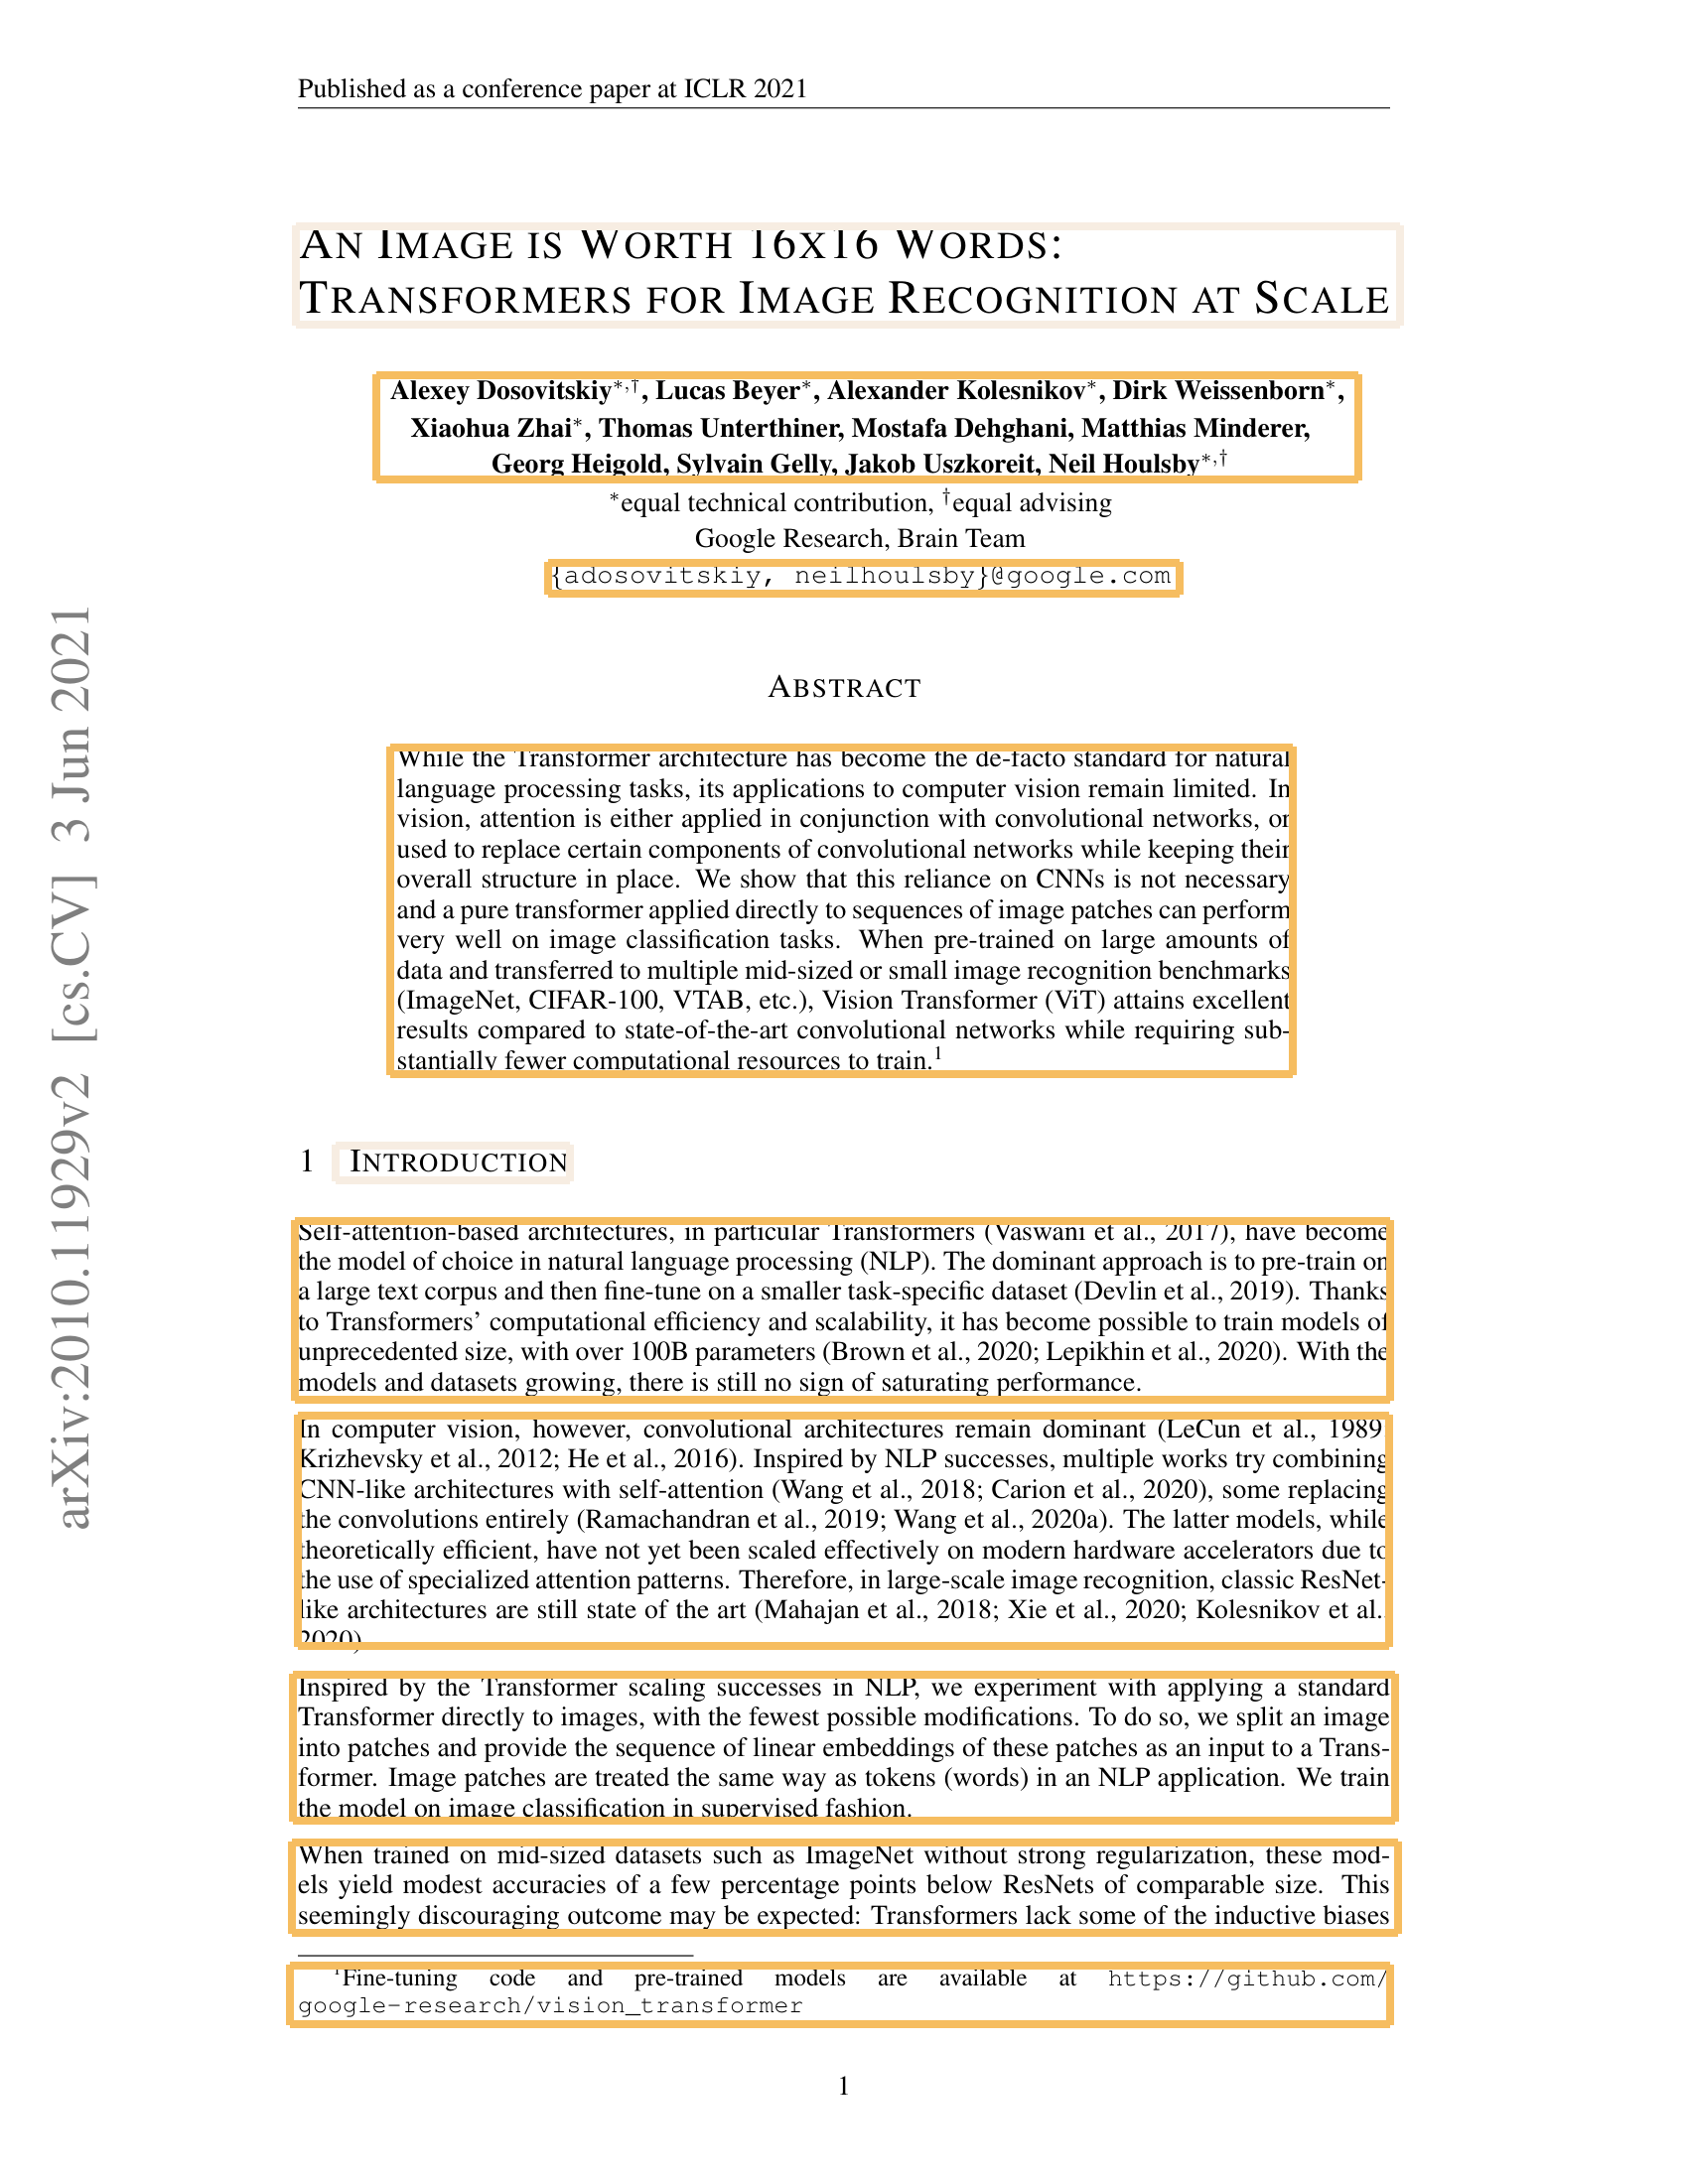

In [7]:
import layoutparser as lp
page = doc[0]
layout = pipeline.model.detect(page)
lp.draw_box(page, layout)